In [338]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [339]:
#Check number of prefectures in data
prefectures = pd.read_csv('prefecture_code.csv')
prefectures

,Code,JpName,EnName
0,1,北海道,Hokkaido
1,2,青森県,Aomori
2,3,岩手県,Iwate
3,4,宮城県,Miyagi
4,5,秋田県,Akita
5,6,山形県,Yamagata
6,7,福島県,Fukushima
7,8,茨城県,Ibaraki
8,9,栃木県,Tochigi
9,10,群馬県,Gunma


A total of 47 prefectures is in the trade_prices csv files, from this we're going to check the number of columns and what might be relevant

In [340]:
#Opening of one of the trade_prices csv file
df = pd.read_csv('trade_prices//01.csv')
df.head()

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (12,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28.0,...,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,NaN
1,2,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,NaN
2,3,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20.0,...,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,4th quarter 2018,2018,4,Not yet,NaN
3,4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26.0,...,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,NaN
4,5,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,NaN


In [341]:
print(df.shape)
print(df.columns)

(186238, 38)
Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'FloorPlan', 'Area',
       'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding',
       'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks'],
      dtype='object')


From this, it appears that the dataset contains 38 columns and 186238 entries. It can also be noted that the prefecture has not been edited to its prefecture code. All data would now then be loaded into a single pandas DataFrame

In [342]:
df.drop(df.index, inplace=True)
#Describing dtype in each of the column 
df = pd.concat((pd.read_csv(file, dtype={
    'No': 'int64',  'Type': 'category', 'Region': 'category', 'MunicipalityCode': 'category', 'Prefecture': 'category',
    'Municipality': 'category', 'DistrictName': 'category', 'NearestStation': 'category', 'TimeToNearestStation': 'string',
    'MinTimeToNearestStation': 'string', 'MaxTimeToNearestStation': 'string', 'TradePrice': 'float', 'FloorPlan': 'category',
    'Area': 'float', 'AreaIsGreaterFlag': 'bool', 'UnitPrice': 'float', 'PricePerTsubo': 'float', 'LandShape': 'category',
    'Frontage': 'float', 'FrontageIsGreaterFlag': 'bool', 'TotalFloorArea': 'float', 'TotalFloorAreaIsGreaterFlag': 'float',
    'BuildingYear': 'float', 'PrewarBuilding': 'bool', 'Structure': 'category', 'Use': 'category', 'Purpose': 'category',
    'Direction': 'category', 'Classification': 'category', 'Breadth': 'float', 'CityPlanning': 'category',
    'CoverageRatio': 'float', 'FloorAreaRatio': 'float', 'Period': 'category', 'Year': 'int64', 'Quarter': 'int64',
    'Renovation': 'category', 'Remarks': 'string'
}) for file in glob('trade_prices/*.csv')), ignore_index=True)

In [343]:
df.head()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,...,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,<NA>
1,2,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,<NA>
2,3,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,...,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,4th quarter 2018,2018,4,Not yet,<NA>
3,4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,...,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,<NA>
4,5,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,<NA>


From the following columns, the column 'No' can be omitted from the dataset as it would have no purpose on the prediction of real estate prices

As TimeToNearestStation and MinTime and MaxTime ToNearestStation is related to each other where TimeToNearestStation would be a string in which it describes the time range when one could reach the nearest station, this column is also omitted

As the 'Period' Column only pertains to the 'Quarter' Columns, this column can also be removed

The 'Remarks' Column is rarely used, this column is also removed from the dataset.

In [344]:
df.drop(columns=['No','TimeToNearestStation', 'Period', 'Remarks'], inplace=True)
df.head()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,...,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation
0,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,...,Other,South,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4,NaN
1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,...,House,East,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4,NaN
2,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,...,House,NaN,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,2018,4,Not yet
3,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,...,NaN,West,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2,NaN
4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,...,House,West,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2,NaN


In [345]:
#Shows number of missing data in each of the column
print(df.isnull().sum())
print(df.shape)

Type                                 0
Region                         1117077
MunicipalityCode                     0
Prefecture                           0
Municipality                         0
DistrictName                      8275
NearestStation                  565811
MinTimeToNearestStation         590541
MaxTimeToNearestStation         678447
TradePrice                           0
FloorPlan                      3309348
Area                                 0
AreaIsGreaterFlag                    0
UnitPrice                      2522103
PricePerTsubo                  2522103
LandShape                      1127530
Frontage                       1369455
FrontageIsGreaterFlag                0
TotalFloorArea                 2588858
TotalFloorAreaIsGreaterFlag          0
BuildingYear                   2036714
PrewarBuilding                       0
Structure                      1993945
Use                            2020044
Purpose                        2723740
Direction                

Columns in which more than 1 million records of data is missing would be omitted, the following columns are:
- Floor Plan
- Structure
- Use
- Purpose
- Renovation
- Region
- Unit Price
- PricePerTsubo
- LandShape
- Frontage
- TotalFloorArea
- BuildingYear
- Structure
- Use
- Purpose
- Direction
- Classification
- Breadth

In [346]:
df.drop(columns=['FloorPlan','Structure', 'Use', 'Purpose', 'Renovation', 'Region' ,'UnitPrice',
                'PricePerTsubo', 'LandShape', 'Frontage', 'TotalFloorArea','BuildingYear','Structure','Use',
                'Purpose','Direction','Classification','Breadth'], inplace=True)
df.head()

,Type,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,1100.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4
1,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,310.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4
2,"Pre-owned Condominiums, etc.",1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,95.0,False,False,0.0,False,Neighborhood Commercial Zone,80.0,200.0,2018,4
3,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,290.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2
4,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,430.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2


In [347]:
print(df.isnull().sum())
print(df.shape)

Type                                0
MunicipalityCode                    0
Prefecture                          0
Municipality                        0
DistrictName                     8275
NearestStation                 565811
MinTimeToNearestStation        590541
MaxTimeToNearestStation        678447
TradePrice                          0
Area                                0
AreaIsGreaterFlag                   0
FrontageIsGreaterFlag               0
TotalFloorAreaIsGreaterFlag         0
PrewarBuilding                      0
CityPlanning                   530666
CoverageRatio                  714641
FloorAreaRatio                 714641
Year                                0
Quarter                             0
dtype: int64
(3906518, 19)


The remaining data that have null values would be removed from the dataset

In [348]:
df = df.dropna()
print(df.isnull().sum())
print(df.shape)

Type                           0
MunicipalityCode               0
Prefecture                     0
Municipality                   0
DistrictName                   0
NearestStation                 0
MinTimeToNearestStation        0
MaxTimeToNearestStation        0
TradePrice                     0
Area                           0
AreaIsGreaterFlag              0
FrontageIsGreaterFlag          0
TotalFloorAreaIsGreaterFlag    0
PrewarBuilding                 0
CityPlanning                   0
CoverageRatio                  0
FloorAreaRatio                 0
Year                           0
Quarter                        0
dtype: int64
(3077722, 19)


From this, it appears that approximately 3.07 million records would be used for the training and testing of the dataset.

The model would be attempting to predict the TradePrice column based on the values of the other columns.

In [349]:
#Know correlation between data, data that has a correlation value of more than 0.5 would have one of the columns be omitted
df.corr()

,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CoverageRatio,FloorAreaRatio,Year,Quarter
TradePrice,1.000000,0.183885,0.181598,0.136064,0.288844,0.000520,0.041112,0.082946,-0.012940,-0.007162
Area,0.183885,1.000000,0.681670,0.463064,0.197990,0.000736,-0.055481,-0.099257,0.014769,0.000479
AreaIsGreaterFlag,0.181598,0.681670,1.000000,0.492015,0.204042,0.000681,-0.000987,-0.013673,0.002282,-0.005017
FrontageIsGreaterFlag,0.136064,0.463064,0.492015,1.000000,0.151547,-0.000056,0.001691,-0.013214,0.001489,-0.004655
TotalFloorAreaIsGreaterFlag,0.288844,0.197990,0.204042,0.151547,1.000000,0.003126,0.040546,0.056547,-0.003814,-0.004928
PrewarBuilding,0.000520,0.000736,0.000681,-0.000056,0.003126,1.000000,0.011964,0.008831,-0.000389,0.000735
CoverageRatio,0.041112,-0.055481,-0.000987,0.001691,0.040546,0.011964,1.000000,0.790854,0.022179,-0.004675
FloorAreaRatio,0.082946,-0.099257,-0.013673,-0.013214,0.056547,0.008831,0.790854,1.000000,0.016625,-0.006931
Year,-0.012940,0.014769,0.002282,0.001489,-0.003814,-0.000389,0.022179,0.016625,1.000000,-0.095817
Quarter,-0.007162,0.000479,-0.005017,-0.004655,-0.004928,0.000735,-0.004675,-0.006931,-0.095817,1.000000


From the data given above, the columns
- Area : AreaIsGreaterFlag
- FloorAreaRatio : CoverageRatio
Are moderately to highly moderated, thus AreaIsGreaterFlag column and CoverageRatio would be dropped from the dataset

In [350]:
df.drop(columns=['AreaIsGreaterFlag', 'CoverageRatio'], inplace=True)
df.head()

,Type,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"Pre-owned Condominiums, etc.",1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,95.0,False,0.0,False,Neighborhood Commercial Zone,200.0,2018,4
3,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,290.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,430.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2


Now, as the data has prices of different real estates from 47 different prefectures, we want to know if there is any difference between the average prices between each of the prefectures

In [351]:
#Conversion of Yen to Million Yen
df['TradePrice'] = df['TradePrice'].div(1000000)

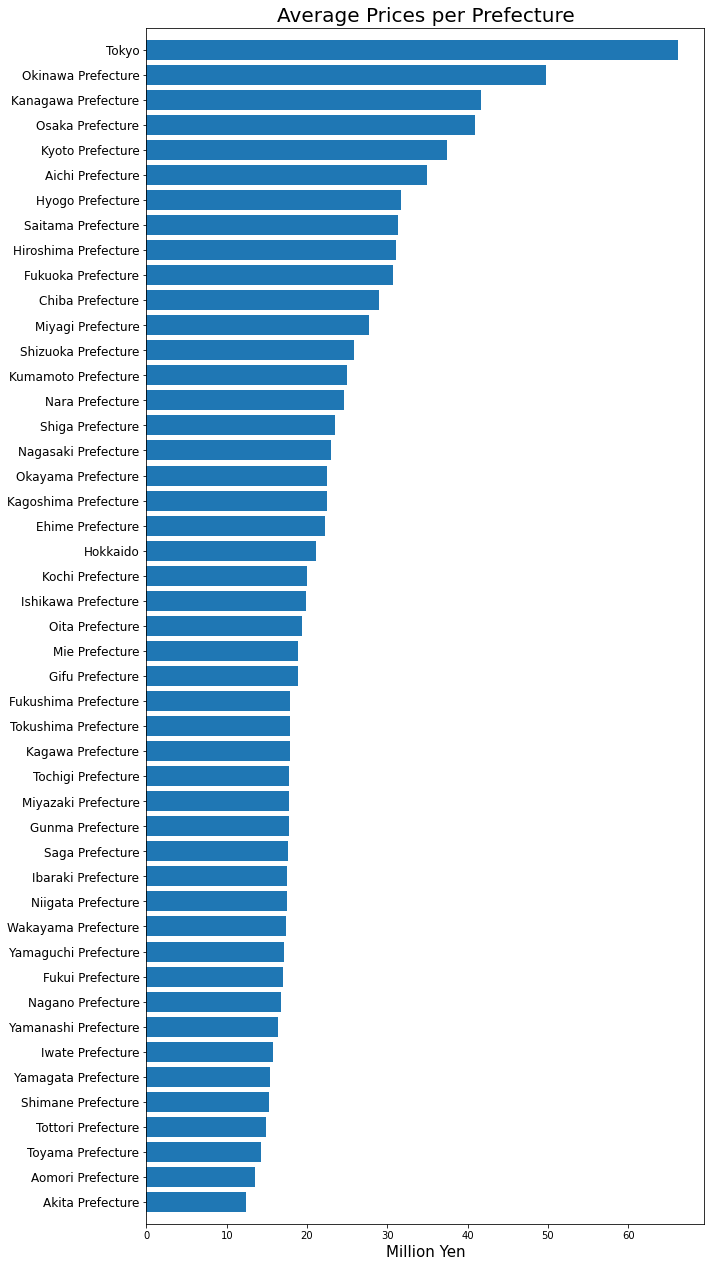

In [352]:
prefectureTP = df.groupby('Prefecture', as_index = False)['TradePrice'].mean().sort_values('TradePrice', ascending=False)
fig, ax = plt.subplots(figsize=(10,22))
ax.barh(prefectureTP['Prefecture'], prefectureTP['TradePrice'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title('Average Prices per Prefecture', fontsize=20)
plt.yticks(fontsize=12)
plt.show()

From the horizontal bar graph given, it appears that one of the driving factors for the price of a property is the location of the property itself. For further analysis, the different municipalities per prefecture would be compared if it also affects the mean price of a location

In [353]:
print(len(df['Municipality'].unique()))
print(len(df.loc[df['Prefecture'] == 'Tokyo']['Municipality'].unique()))

1461
51


As the total number of prefecture per Municipality is too high, a sample would just be taken where five prefecture would be chosen where their own municipalities property price would be compared amongst each other.

In [354]:
def getMunicipalityAveragePrice(prefecture):
    MuniTP = df.loc[df['Prefecture'] == prefecture].groupby('Municipality', 
                                                              as_index = False).mean().sort_values('TradePrice', ascending = False)

    fig, ax = plt.subplots(figsize=(10,22))
    ax.barh(MuniTP['Municipality'], MuniTP['TradePrice'])
    ax.invert_yaxis()
    ax.margins(y=0.01)
    ax.set_xlabel('Million Yen', fontsize = 15)
    ax.set_title(f'Average Prices per Municipality in {prefecture}', fontsize=20)
    plt.yticks(fontsize=12)
    plt.show()
    del fig,ax

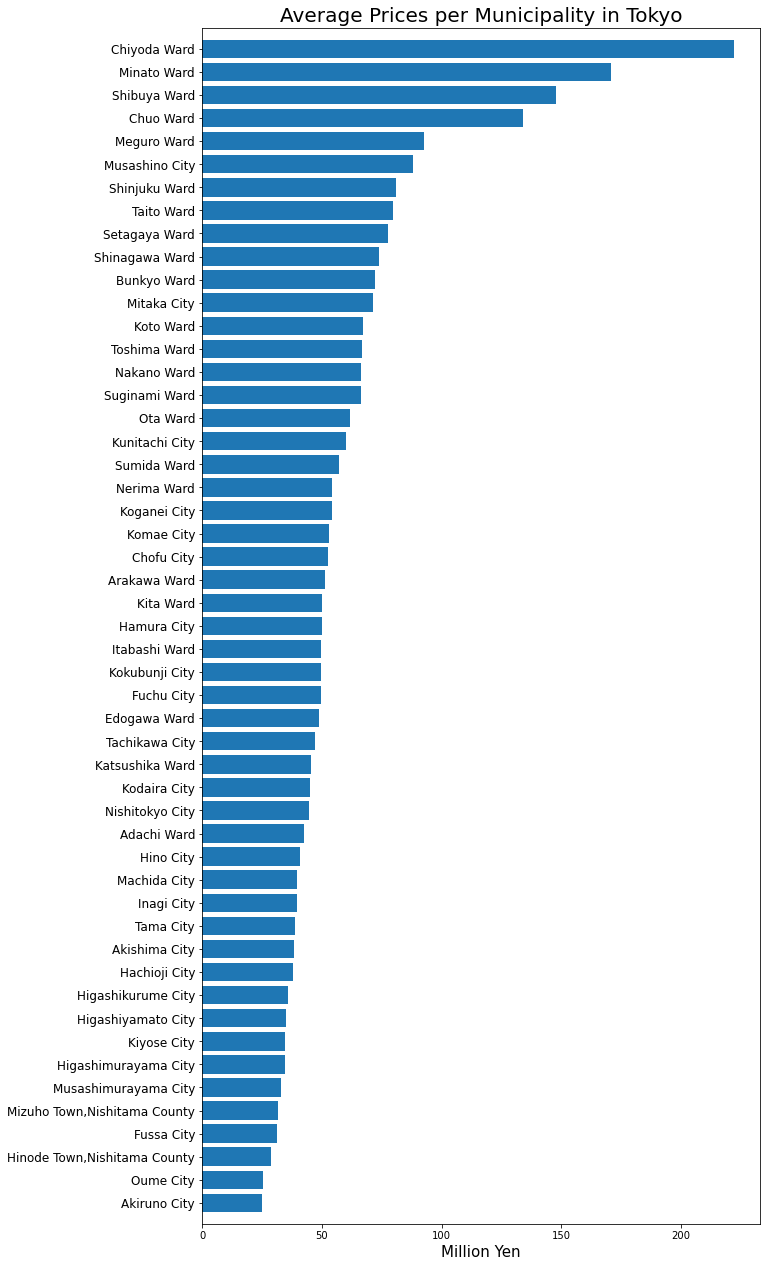

In [355]:
getMunicipalityAveragePrice('Tokyo')

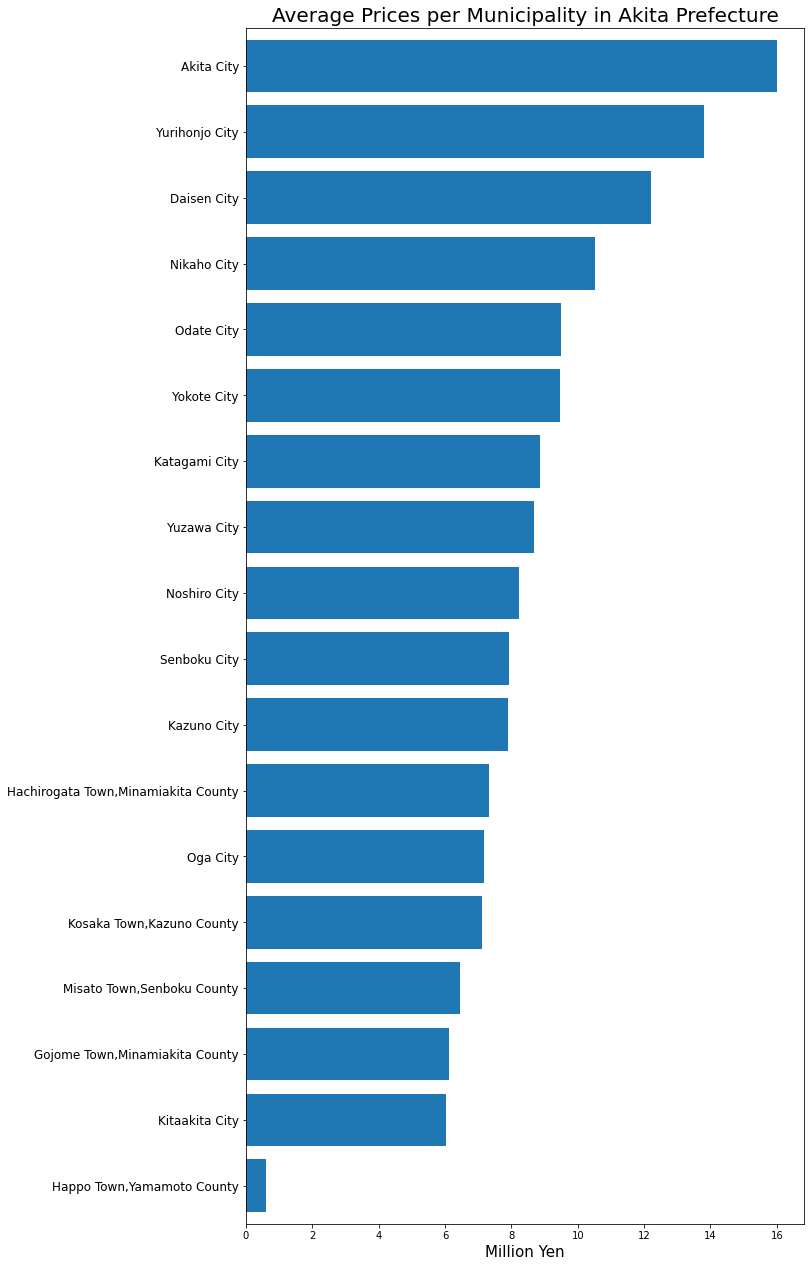

In [356]:
getMunicipalityAveragePrice('Akita Prefecture')

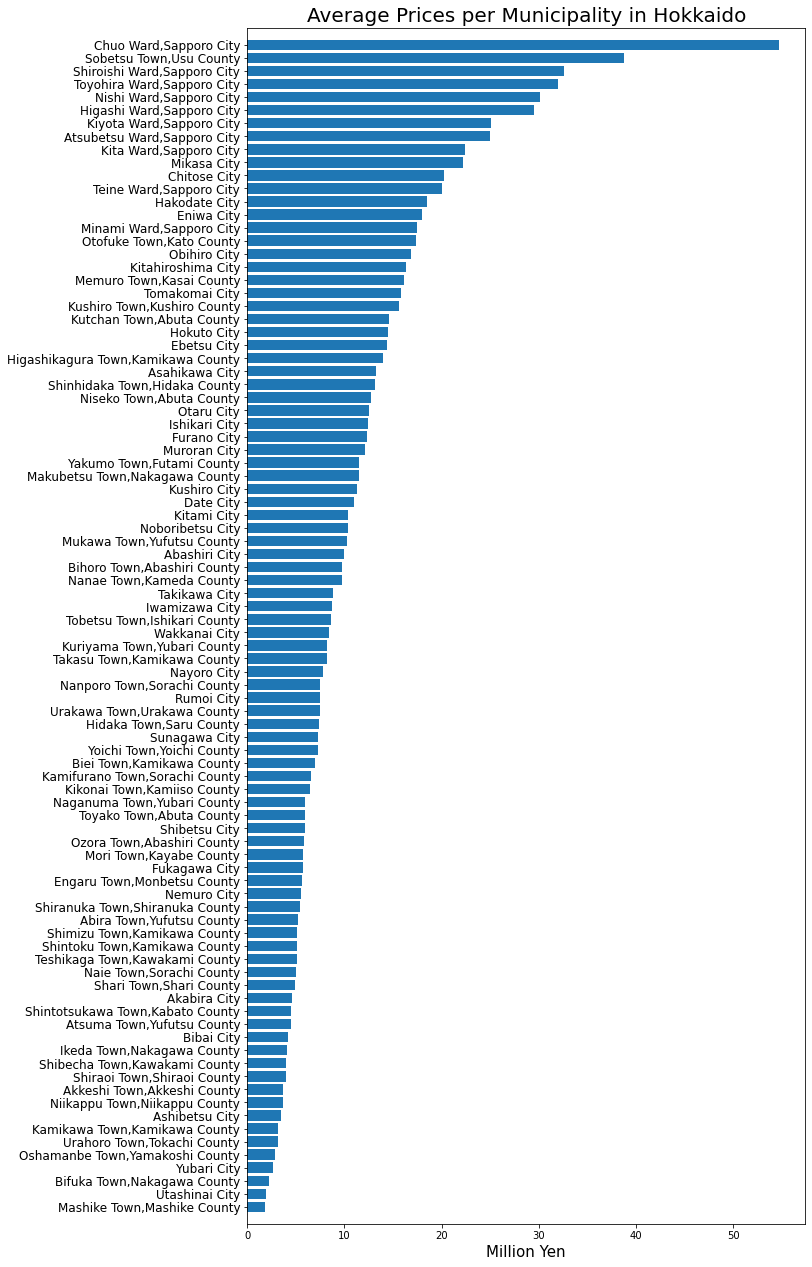

In [357]:
getMunicipalityAveragePrice('Hokkaido')

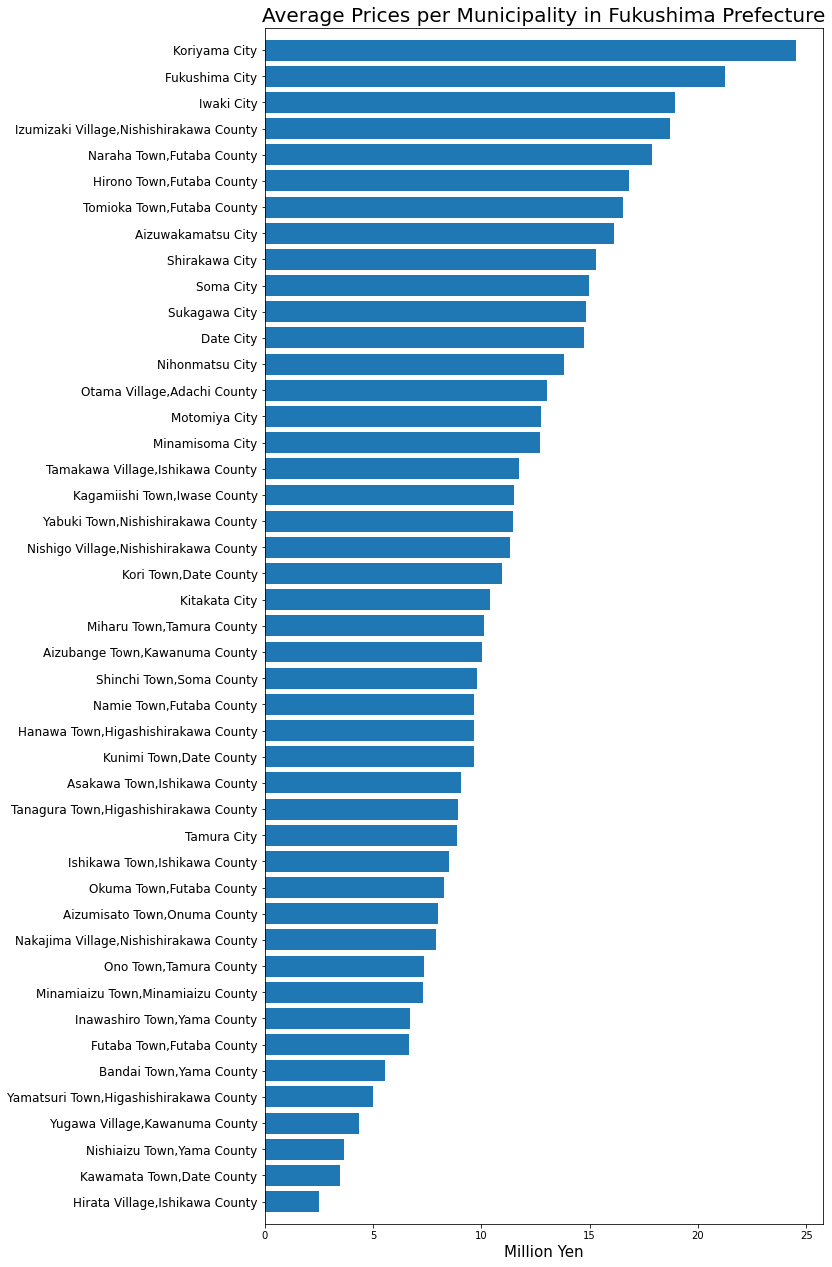

In [358]:
getMunicipalityAveragePrice('Fukushima Prefecture')

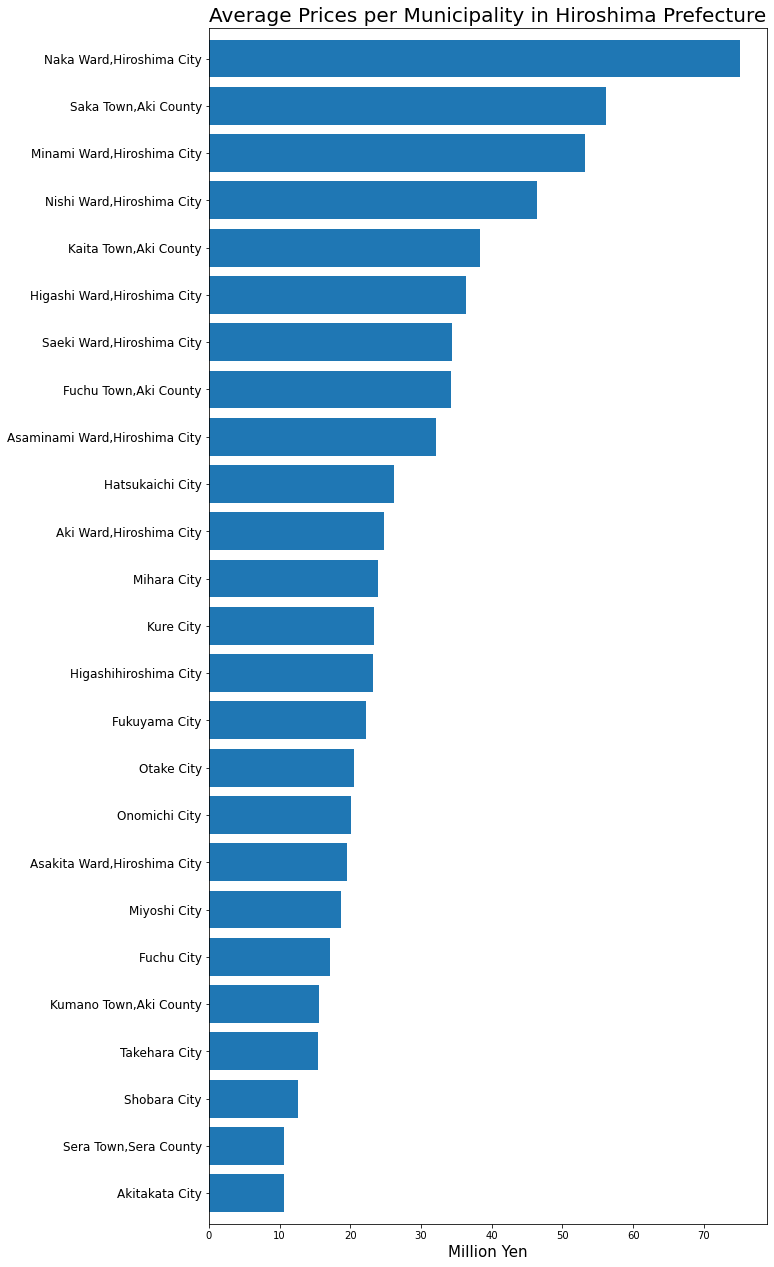

In [359]:
getMunicipalityAveragePrice('Hiroshima Prefecture')

With the following information, it can be safely assumed that prices also widely varies within a prefecture; where-in average property prices is widely different in a single prefecture in different municipalities. The difference between the average could be almost or more than ten-fold as such the example in Hokkaido's case (Mashike Town, Mashike County and Chuo Ward, Sapporo City). As the Prefecture is a larger body where-in the Municipality is located, and it has been found out that different municipalities can widely affect the price of a certain location, the prefecture column could be dropped.

Additionally, as the MunicipalityCode only pertains to the Municipality, MunicipalityCode column would also be dropped

In [360]:
df.drop(columns=['Prefecture', 'MunicipalityCode'], inplace= True)
df.head()

,Type,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86.0,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38.0,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"Pre-owned Condominiums, etc.","Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19.0,95.0,False,0.0,False,Neighborhood Commercial Zone,200.0,2018,4
3,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5.0,290.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,Residential Land(Land Only),"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25.0,430.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2


To further process the data, municipalities with only count of less than 10 will be removed.

In [361]:
numMunicipality = df['Municipality'].value_counts(dropna=True, sort=True)

In [362]:
for mncplt in numMunicipality.keys():
    if numMunicipality[mncplt] < 10:
        df.drop(df[df['Municipality'] == mncplt].index, inplace=True)
df.shape

(3077570, 15)

In [363]:
df['Type'].unique()

['Residential Land(Land Only)', 'Pre-owned Condominiums, etc.', 'Residential Land(Land and Building)']
Categories (5, object): ['Agricultural Land', 'Forest Land', 'Pre-owned Condominiums, etc.', 'Residential Land(Land Only)', 'Residential Land(Land and Building)']

Moving to the *Type* column, there are three known categories. The average prices of each category would now be computed to see if there is a significant difference between the prices of these properties

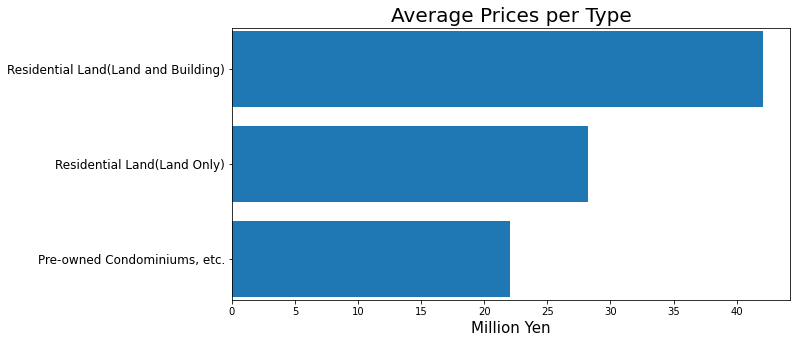

In [364]:
propertyType = df.groupby('Type', as_index = False).mean().sort_values('TradePrice', ascending = False)

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(propertyType['Type'], propertyType['TradePrice'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title(f'Average Prices per Type', fontsize=20)
plt.yticks(fontsize=12)
plt.show()

From the following, the type variable could prove useful in determining the price of a property, thus the *type* column would be hot-encoded as to make it easier for the model to use the data

In [365]:
df['Type'] = df['Type'].replace(['Residential Land(Land Only)'], 0)
df['Type'] = df['Type'].replace(['Pre-owned Condominiums, etc.'], 1)
df['Type'] = df['Type'].replace(['Residential Land(Land and Building)'], 2)
typeCat = list(to_categorical(df['Type']))
df['Type'] = df['Type'].astype('object')
df['Type'] = typeCat
del typeCat

In [369]:
df.head()

,Type,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86.0,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38.0,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"[0.0, 1.0, 0.0]","Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19.0,95.0,False,0.0,False,Neighborhood Commercial Zone,200.0,2018,4
3,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5.0,290.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25.0,430.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2


Moving onto the *DistrictName* column, as this column is only based from the Municipality itself, where-in the District is a location within a Municipality, further dividing each Municipality to districts would further diversify the data. This column would then be omitted

Furthermore, the column *NearestStation* could also be removed as it only describes what the name of the Station that is nearest to the location, the columns *MinTimeToNearestStation* and *MaxTimeToNearestStation* could have more valuable data compared to the column *NearestStation*.

In [372]:
df.drop(columns=['DistrictName', 'NearestStation'], inplace = True)

In [373]:
df.head()

,Type,Municipality,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",28,28,86.0,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",27,27,38.0,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"[0.0, 1.0, 0.0]","Chuo Ward,Sapporo City",20,20,19.0,95.0,False,0.0,False,Neighborhood Commercial Zone,200.0,2018,4
3,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",26,26,5.0,290.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",23,23,25.0,430.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2


The number of unique values for the column *CityPlanning* is 16, the TradePrice mean of these unique values would be taken as to see if different CityPlanning categories can affect the price of a certain property.

In [375]:
len(df['CityPlanning'].unique())

16

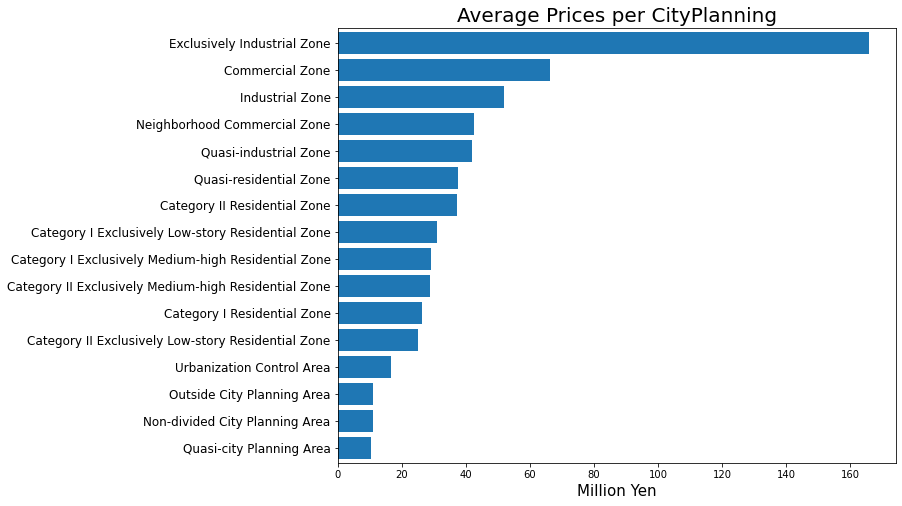

In [384]:
CityPlanningPrice = df.groupby('CityPlanning', as_index = False).mean().sort_values('TradePrice', ascending = False)

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(CityPlanningPrice['CityPlanning'], CityPlanningPrice['TradePrice'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title(f'Average Prices per CityPlanning', fontsize=20)
plt.yticks(fontsize=12)
plt.show()

In [389]:
CityPlanningPrice[['CityPlanning','TradePrice']].head()
del CityPlanningPrice

In [391]:
df

,Type,Municipality,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",28,28,86.0,1100.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",27,27,38.0,310.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"[0.0, 1.0, 0.0]","Chuo Ward,Sapporo City",20,20,19.0,95.0,False,0.0,False,Neighborhood Commercial Zone,200.0,2018,4
3,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",26,26,5.0,290.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,"[1.0, 0.0, 0.0]","Chuo Ward,Sapporo City",23,23,25.0,430.0,False,0.0,False,Category I Exclusively Low-story Residential Zone,80.0,2018,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902887,"[1.0, 0.0, 0.0]",Naha City,11,11,18.0,100.0,False,0.0,False,Category II Residential Zone,200.0,2007,3
3902888,"[1.0, 0.0, 0.0]",Naha City,11,11,14.0,80.0,False,0.0,False,Category II Residential Zone,200.0,2007,3
3902889,"[1.0, 0.0, 0.0]",Naha City,11,11,8.3,45.0,False,0.0,False,Category II Residential Zone,200.0,2007,3
3902890,"[1.0, 0.0, 0.0]",Naha City,10,10,61.0,280.0,False,0.0,False,Commercial Zone,400.0,2007,2
